In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
sampling_f = 32000 # sampling frequency in Hz
sample_length = 1 # sample duration in seconds
hop_length = 1024 # number of samples between 2 analysis points
n_frames = 32# number of frames for each sample
n_mfcc = 32 # number of coefficients for the mfcc analysis 
row_length = n_mfcc*n_frames #define the row length
print('row length: ', row_length)
print('number of frames: ', n_frames)

row length:  1024
number of frames:  32


## Data Preparation 

In [3]:
parent_wd = os.getcwd()
X_test0 = np.load(parent_wd+'\\data\\X_3d_test.npy')
X_test = X_test0.reshape(-1, 32, 32, 3)
X_train_valid0 = np.load(parent_wd+'\\data\\X_3d_train.npy')
X_train_valid = X_train_valid0.reshape(-1, 32, 32, 3)
y_test = np.load(parent_wd+'\\data\\y_3d_test.npy')
y_train_valid = np.load(parent_wd+'\\data\\y_3d_train.npy')

# Split the training set in validation and tarining
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, y_train_valid, test_size=0.3, random_state=0) 

In [4]:
print('Train:', X_train.shape, y_train.shape)
print('Valid:', X_valid.shape, y_valid.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (1991, 32, 32, 3) (1991,)
Valid: (854, 32, 32, 3) (854,)
Test: (707, 32, 32, 3) (707,)


In [5]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)
    
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

## CNN in 3 dimensions

In [6]:
# Create new graph
graph = tf.Graph()

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    print('Input:', X.shape)
    
    # Convolutional layer (64 filters, 3x3, stride: 1 x 2)
    conv1 = tf.layers.conv2d(
        X, 64, (5, 5), (2, 2), 'SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.01, seed=0),
        name='conv1'
    )
    print('Convolutional layer:', conv1.shape)
    
    # Maxpool layer (2x2, stride: 1 x 3, "same" padding)
    pool1 = tf.layers.max_pooling2d(conv1, (2, 2), (2, 2), 'SAME')
    print('Maxpool:', pool1.shape)
    
    # Convolutional layer (64 filters, 3x3, stride: 1 x 1)
    conv2 = tf.layers.conv2d(
        pool1, 64, (3, 3), (1, 1), 'SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.01, seed=0),
        name='conv2'
    )
    print('Convolutional layer:', conv2.shape)
    
    # Maxpool layer (2x2, stride: 3, "same" padding)
    pool2 = tf.layers.max_pooling2d(conv2, (2, 2), (2, 2), 'SAME')
    print('Maxpool:', pool2.shape)
    
    # Flatten output
    flat_output = tf.contrib.layers.flatten(pool2)
    print('Flatten:', flat_output.shape)
    
    # Fully connected layer 1
    fc = tf.layers.dense(
        flat_output, 64, # 64 hidden units
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    print('Fully-connected layer 1:', fc.shape)
    
    # Output layer
    logits = tf.layers.dense(
        fc, 10, # One output unit per category
        activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    print('Output layer:', logits.shape)
    
    # Kernel of the 1st conv. layer
    with tf.variable_scope('conv1', reuse=True):
        conv_kernels = tf.get_variable('kernel')
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
    
    # Adam optimizer
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.AdamOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)
    
    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

Input: (?, 32, 32, 3)
Convolutional layer: (?, 16, 16, 64)
Maxpool: (?, 8, 8, 64)
Convolutional layer: (?, 8, 8, 64)
Maxpool: (?, 4, 4, 64)
Flatten: (?, 1024)
Fully-connected layer 1: (?, 64)
Output layer: (?, 10)


In [7]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    # Set seed
    np.random.seed(0)
    # Train several epochs
    for epoch in range(40):
        # Accuracy values (train) after each batch
        batch_acc = []
        
        for X_batch, y_batch in get_batches(X_train, y_train, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.01 # Learning rate                
            })

            # Save accuracy (current batch)
            batch_acc.append(acc_value)
        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid,
            y: y_valid
        })
        valid_acc_values.append(valid_acc)
    
     #Evaluate test accuracy
    test_acc = sess.run(accuracy, feed_dict={
        X: X_test,
        y: y_test
    })
    print('Test accuracy: {:.3f}'.format(test_acc))

Test accuracy: 0.611


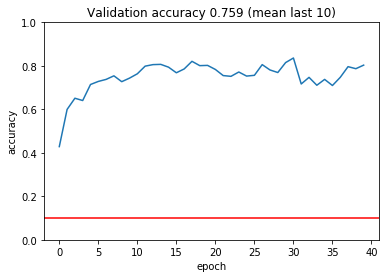

In [8]:
# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy {:.3f} (mean last 10)'.format(
    np.mean(valid_acc_values[-10:]) # last ten values
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0,1)
plt.axhline(y=0.1, color='r', linestyle='-')
plt.show()